In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    start_mem = df.memory_usage().sum()
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum()
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
sample_feature = reduce_mem_usage(pd.read_csv('data_for_tree.csv'))

Memory usage of dataframe is 62099672.00 MB
Memory usage after optimization is: 16520303.00 MB
Decreased by 73.4%


In [4]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model']]

In [5]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]
train_X = train[continuous_feature_names]
train_y = train['price']

In [6]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
model = model.fit(train_X, train_y)

In [7]:
'intercept:'+ str(model.intercept_)
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('v_6', 3367064.3416418917),
 ('v_8', 700675.5609399228),
 ('v_9', 170630.27723227345),
 ('v_7', 32322.66193206365),
 ('v_12', 20473.670796960145),
 ('v_3', 17868.079541493513),
 ('v_11', 11474.938996708634),
 ('v_13', 11261.764560014306),
 ('v_10', 2683.9200905964526),
 ('gearbox', 881.822503924652),
 ('fuelType', 363.90425072163896),
 ('bodyType', 189.6027101207624),
 ('city', 44.9497512052271),
 ('power', 28.553901616754473),
 ('brand_price_median', 0.5103728134078852),
 ('brand_price_std', 0.4503634709262776),
 ('brand_amount', 0.14881120395064726),
 ('brand_price_max', 0.0031910186703109577),
 ('SaleID', 5.3559899198566084e-05),
 ('seller', 3.095250576734543e-06),
 ('train', 4.861503839492798e-07),
 ('offerType', 4.100147634744644e-07),
 ('brand_price_sum', -2.1750068681873895e-05),
 ('name', -0.00029800127130737337),
 ('used_time', -0.002515894332833883),
 ('brand_price_average', -0.4049048451011075),
 ('brand_price_min', -2.246775348688368),
 ('power_bin', -34.420644117277035),

In [8]:
from matplotlib import pyplot as plt

In [9]:
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

The predicted price is obvious different from true price


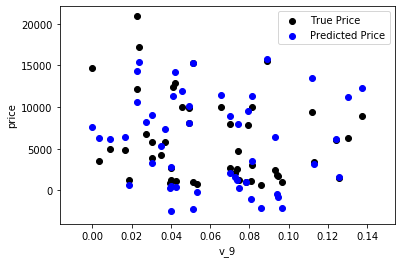

In [10]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

It is clear to see the price shows a typical exponential distribution


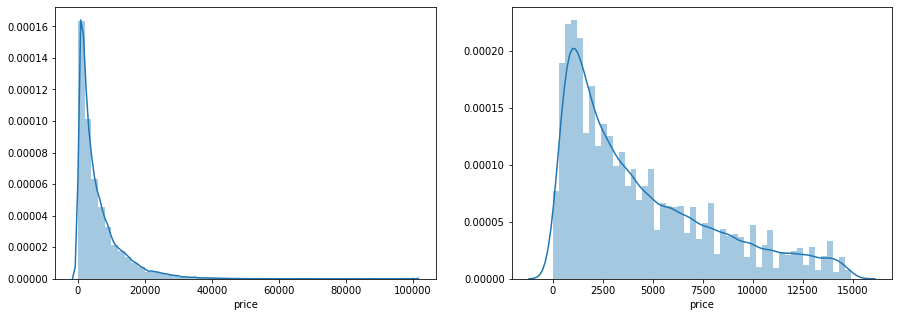

In [11]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

In [12]:
train_y_ln = np.log(train_y + 1)

The transformed price seems like normal distribution


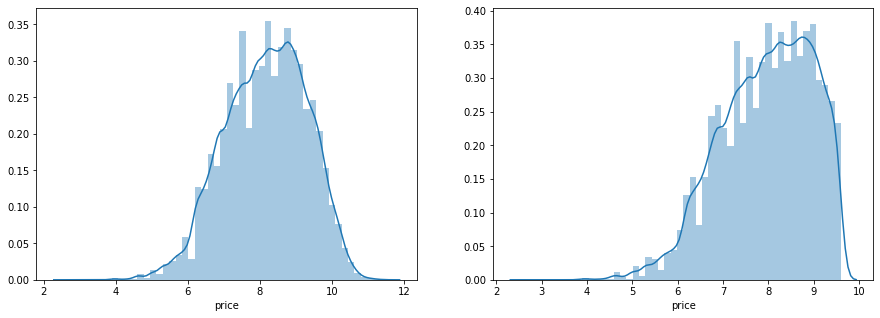

In [13]:
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [14]:
model = model.fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:18.7507454600906


[('v_9', 8.052411927756225),
 ('v_5', 5.764248502260436),
 ('v_12', 1.6182066744719383),
 ('v_1', 1.4798302934418999),
 ('v_11', 1.1669014496950592),
 ('v_13', 0.9404706038649688),
 ('v_7', 0.7137295307876452),
 ('v_3', 0.6837865320348406),
 ('v_0', 0.008500525238529401),
 ('power_bin', 0.008497967226210105),
 ('gearbox', 0.007922377819946261),
 ('fuelType', 0.006684768278655773),
 ('bodyType', 0.004523520659140599),
 ('power', 0.0007161896117538986),
 ('brand_price_min', 3.334353082746419e-05),
 ('brand_amount', 2.8978800102552237e-06),
 ('brand_price_median', 1.2571119996621528e-06),
 ('brand_price_std', 6.659134278556847e-07),
 ('brand_price_max', 6.194957240894296e-07),
 ('brand_price_average', 5.999429489174207e-07),
 ('SaleID', 2.11941620665444e-08),
 ('offerType', 7.085532160999719e-11),
 ('train', -2.9558577807620168e-12),
 ('seller', -7.888445452408632e-11),
 ('brand_price_sum', -1.5126510445832602e-10),
 ('name', -7.015510649935241e-08),
 ('used_time', -4.122477171059761e-06)

The predicted price seems normal after np.log transforming


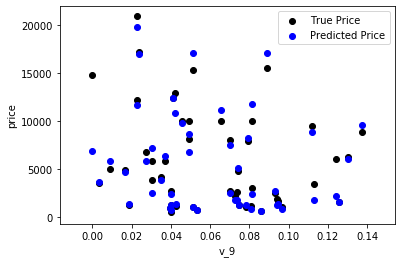

In [15]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

In [17]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

In [18]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished


In [19]:
print('AVG:', np.mean(scores))

AVG: 1.3658024042408086


In [20]:
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished


In [21]:
print('AVG:', np.mean(scores))

AVG: 0.19325301535176892


In [22]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.190792,0.193758,0.194132,0.191825,0.195758


In [23]:
import datetime

In [24]:
sample_feature = sample_feature.reset_index(drop=True)

In [25]:
split_point = len(sample_feature) // 5 * 4

In [26]:
train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()
train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)

In [27]:
model = model.fit(train_X, train_y_ln)

In [28]:
mean_absolute_error(val_y_ln, model.predict(val_X))

0.19577667040507427

In [29]:
from sklearn.model_selection import learning_curve, validation_curve

In [30]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(0.05,1,20)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training example')
    plt.ylabel('score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()#区域
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std, alpha=0.1,
    color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std, alpha=0.1,
    color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
    label="Training score")
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",
    label="Cross-validation score")
    plt.legend(loc="best")
    return plt

In [32]:
train = sample_feature[continuous_feature_names + ['price']].dropna()
train_X = train[continuous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [34]:
models = [LinearRegression(),
Ridge(),
Lasso()]

In [35]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
Ridge is finished
Lasso is finished


In [36]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,Ridge,Lasso
cv1,0.190792,0.194832,0.383899
cv2,0.193758,0.197632,0.381893
cv3,0.194132,0.198123,0.384090
cv4,0.191825,0.195670,0.380526
cv5,0.195758,0.199676,0.383611


intercept:18.750754532638016


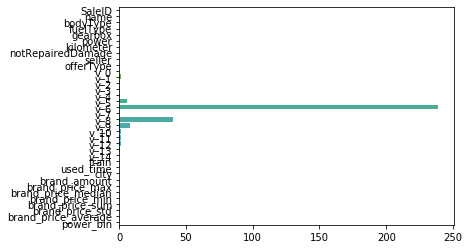

In [37]:
model = LinearRegression().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept:4.671710856875326


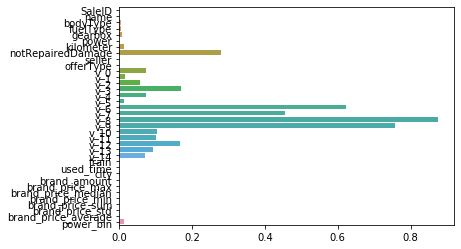

In [38]:
model = Ridge().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept:8.672182455497687


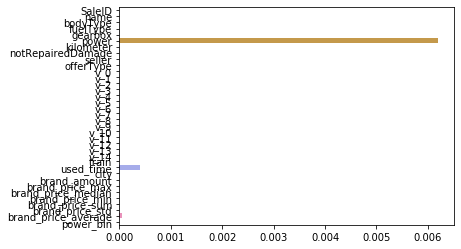

In [39]:
model = Lasso().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

In [44]:
models = [LinearRegression(),
            DecisionTreeRegressor()
            #RandomForestRegressor(),
            #GradientBoostingRegressor(),
            #MLPRegressor(solver='lbfgs', max_iter=100),
            #XGBRegressor(n_estimators = 100, objective='reg:squarederror'),
            #LGBMRegressor(n_estimators = 100)
            ]

In [45]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
DecisionTreeRegressor is finished


In [ ]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

In [ ]:
objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']
num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,20,40, 55]
bagging_fraction = []
feature_fraction = []
drop_rate = []

In [ ]:
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    best_obj[obj] = score
    best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    best_leaves[leaves] = score
    best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
    num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
    max_depth=depth)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    best_depth[depth] = score

In [ ]:
sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'], y=[0.143 ,min(best_leaves)])

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {'objective': objective , 'num_leaves': num_leaves, 'max_depth': max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_X, train_y)

In [ ]:
clf.best_params_

In [ ]:
model = LGBMRegressor(objective='regression',
num_leaves=55,
max_depth=15)

In [ ]:
np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))